In [1]:
### CW2 - Q1 ###

In [2]:
### Part A

In [3]:
#import relevant packages
%matplotlib inline
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [4]:
def problem14(x):
    '''
    Python representation of function 14, defined in range [0,4]
    '''
    f = -1.0*np.exp(-x) * np.sin(2.0*np.pi*x)
    return f

In [5]:
def initial_sample(n_init, x_low, x_high, function):
    '''
    function to randomly sample points in defined function

    ##INPUT##
    n_init:    number of initial points to sample
    x_low:     lower limit of x
    x_high:    upper limit of x
    function:  objective function to sample from 

    ##OUTPUT##
    x_train:   array
               x values sampled
    y_train:   array
               y values sampled using test function
    '''

    x_train = np.random.uniform(x_low,x_high,n_init)

    x_train = x_train[:,None]
    y_train = function(x_train)

    return x_train, y_train

In [6]:
def train_gaussian_process(x_train,y_train):
    '''
    Function to train gaussian process regression model
    '''
    kernel=RBF()
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25, normalize_y = False)
    gpr.fit(x_train, y_train)

    return gpr

In [7]:
#define variables
n_init = int(5)
x_low = float(0)
x_high = float(4)

In [8]:
#sample points to initialise arrays for test data
x_train, y_train = initial_sample(n_init, x_low, x_high, problem14)

In [9]:
#train gaussian process regression model
gpr = train_gaussian_process(x_train,y_train)

In [10]:
#define true function over range [0,4]
x_vals = np.linspace(x_low, x_high, 2000)
y_vals = problem14(x_vals)

#calculated predicted values using model
gpr_pred, gpr_std = gpr.predict(x_vals[:,None],return_std=True)
gpr_std=gpr_std[:,None]      #ensure standard deviation array is same shape as prediction array

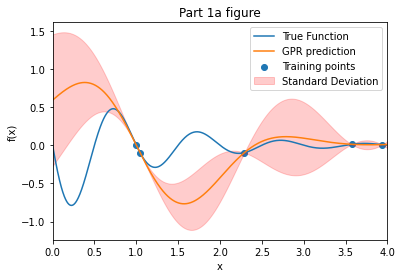

In [11]:
#plot figure showing true function, prediction, the points sampled
plt.plot(x_vals,y_vals,label='True Function')
plt.scatter(x_train,y_train,label='Training points')
plt.plot(x_vals, gpr_pred, label='GPR prediction')
#plot standard deviation
std_upper = gpr_pred+gpr_std
std_lower = gpr_pred-gpr_std
plt.fill_between(x_vals, std_lower.reshape(1,-1)[0], std_upper.reshape(1,-1)[0], color='red', alpha=0.2, label='Standard Deviation')
#plot title, labels, limits, legend
plt.title('Part 1a figure')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(x_low,x_high)
plt.legend()
plt.show()

In [12]:
### Part B

In [13]:
from scipy.stats import norm

In [14]:
def prob_of_improvement(y_pred,std_dev,T):
    '''
    function to calculate probability of improvement

    ##INPUT##
    y_pred:    GPR prediciton
               array
    std_dev:   standard deviation in prediction at x
               array
    T:         Target value
               scalar

    ##OUTPUT##
    POI:       POI for each x value
               array
    '''

    arg = (T - y_pred)/std_dev
    POI = norm.cdf(arg)

    return POI

In [15]:
#define target values, T and calculate POI values
T_vals=np.linspace(min(y_vals), min(y_train), 3)

T1 = T_vals[-1]
POI_vals1 = prob_of_improvement(gpr_pred,gpr_std,T1)
T2 = T_vals[-2]
POI_vals2 = prob_of_improvement(gpr_pred,gpr_std,T2)
T3 = T_vals[-3]
POI_vals3 = prob_of_improvement(gpr_pred,gpr_std,T3)

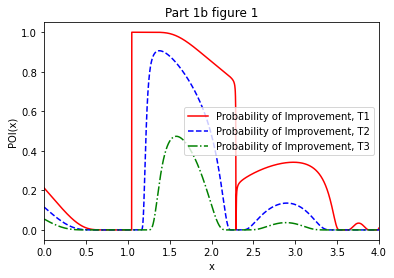

In [16]:
#plot figure - POI for all values of T 
plt.plot(x_vals, POI_vals1,color='red',label="Probability of Improvement, T1", linestyle='-')
plt.plot(x_vals, POI_vals2,color='blue',label="Probability of Improvement, T2", linestyle='--')
plt.plot(x_vals, POI_vals3,color='green',label="Probability of Improvement, T3", linestyle='-.')
plt.title('Part 1b figure 1')
plt.xlabel('x')
plt.ylabel('POI(x)')
plt.xlim(x_low,x_high)
plt.legend()
plt.show()

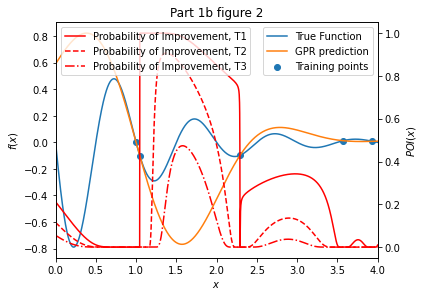

In [17]:
#plot POI values on figure on top of data from part a
fig, ax1 = plt.subplots()
ax1.set_xlabel('$x$')
ax1.set_ylabel('$f(x)$')
# ax1.set_ylim([-1.,1.])
ax1.set_xlim([0.0,4.0])
ax1.plot(x_vals,y_vals,label='True Function') #true function
ax1.plot(x_vals, gpr_pred, label='GPR prediction') #Gaussian process prediction
#ax1.axvline(x=x_best, color='g', linestyle='--')
ax1.scatter(x_train,y_train,label='Training points')#Training points
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('$POI(x)$')
ax2.plot(x_vals, POI_vals1,color='red',label="Probability of Improvement, T1", linestyle='-')
ax2.plot(x_vals, POI_vals2,color='red',label="Probability of Improvement, T2", linestyle='--')
ax2.plot(x_vals, POI_vals3,color='red',label="Probability of Improvement, T3", linestyle='-.')
ax2.tick_params(axis='y')
# ax2.set_ylim([0,4.])
fig.tight_layout() # otherwise the right y-label is slightly clipped
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.title('Part 1b figure 2')
plt.show()

In [18]:
### Part C 

In [19]:
def problem21(x):
    '''
    Python representation of function 21, defined in range [0,10]
    '''
    f = x*np.sin(x) + x*np.cos(2.*x)
    return f

In [20]:
def maximise_acquisition_function(x_vals,gpr,T):
    '''
    function to maximise probability of improvement to choose next best point to evaluate 

    ##INPUT##
    x_vals:    x values at which objective function is evaluated at 
               array
    gpr:       Gaussian Process Regression model 
               object
    T:         Target value
               scalar

    ##OUTPUT##
    x_next:    next best point to evaluate 
    '''
    y_pred, y_std = gpr.predict(x_vals[:,None],return_std=True)
    y_std=y_std[:,None]

    POI_val_array = prob_of_improvement(y_pred,y_std,T)     #poi at each value of x
    POI_max = max(POI_val_array)
    index = np.where(POI_val_array==POI_max)[0][0]
    x_next = x_vals[index]

    return x_next

In [21]:
def Bayesian_optimisation(function, x_low, x_high, iteration_num, n_grid_points):
    '''
    function to perform Bayesian Optimisation loop 

    ##INPUT##
    function:      objective function  
    x_low:         lower bound for objective function  
    x_high:        higher bound for objective function 
    iteration_num: number of iteration of bayesian optimisation to perform 
    n_grid_points: number of points at which objective function is evaluated 
    
    ##OUTPUT##
    (x_new, y_new):    coordinates of best point found during each iteration 
    fig:               plot produced at each iteration to show objective function, gpr prediction, sampled values,
                       standard deviation, and POI
    '''
    
    #define true function over range [x_low,x_high]
    x_vals = np.linspace(x_low, x_high, n_grid_points)
    y_vals = function(x_vals)
    
    #obtain sample points at random
    x_train, y_train = initial_sample(n_init, x_low, x_high, function)
    
    #main loop
    for i in range(iteration_num):
        
        T = min(y_train) - abs(min(y_vals)/(i+1))    #initially weighted for exploration and then towards exploitation

        #train gaussian process regression model using only initial sample points
        gpr = train_gaussian_process(x_train,y_train)

        #calculate predicted values and standard deviation using Gaussian Process model
        y_pred, y_std = gpr.predict(x_vals[:,None],return_std=True)
        y_std = y_std[:,None] #ensure standard deviation array is same shape as prediction array

        #maximise POI function to determine best point to sample next
        x_new = maximise_acquisition_function(x_vals, gpr, T)
        y_new = function(x_new)
        POI_vals = prob_of_improvement(y_pred, y_std, T)

        x_train = np.append(x_train, x_new.reshape(-1,1), axis=0) 
        y_train = np.append(y_train, y_new.reshape(-1,1), axis=0)
    
        print('iteration:    ', i+1, '\n')
        print('Best point found:     ', (x_new, y_new))
    
        #plot all data on figure
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('$x$')
        ax1.set_ylabel('$f(x)$')
        # ax1.set_ylim([-1.,1.])
        ax1.set_xlim([x_low,x_high])
        ax1.plot(x_vals,y_vals,label='True Function') #true function
        ax1.plot(x_vals, y_pred, label='GPR prediction') #Gaussian process prediction
        #plot standard deviation
        std_upper = y_pred+y_std
        std_lower = y_pred-y_std
        plt.fill_between(x_vals, std_lower.reshape(1,-1)[0], std_upper.reshape(1,-1)[0], color='red', alpha=0.2, label='Standard Deviation')
        ax1.scatter(x_train,y_train,label='Training points')#Training points
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('$POI(x)$')
        ax2.plot(x_vals, POI_vals,color='red',label="Probability of Improvement", linestyle='-')
        ax2.tick_params(axis='y')
        fig.tight_layout() # otherwise the right y-label is slightly clipped
        ax1.legend(loc="upper right")
        ax2.legend(loc="upper left")
        plt.show()

iteration:     1 

Best point found:      (2.6053026513256627, 0.04539297643282607)


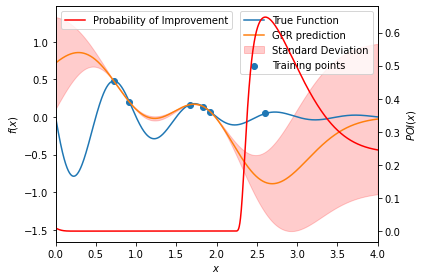

iteration:     2 

Best point found:      (4.0, 1.794415083154168e-17)


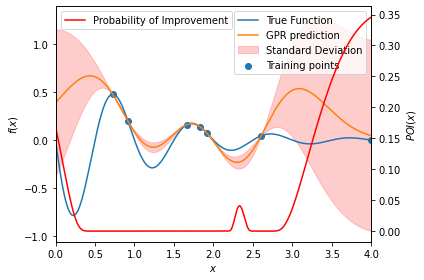

iteration:     3 

Best point found:      (2.3091545772886444, -0.09256179669139443)


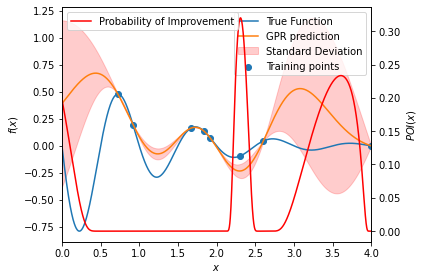

iteration:     4 

Best point found:      (3.281640820410205, -0.036826627356530584)


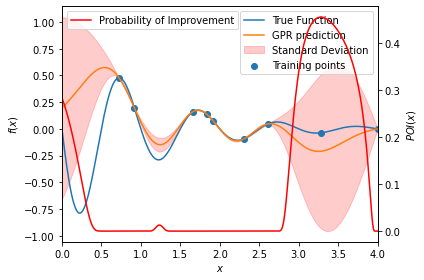

iteration:     5 

Best point found:      (0.0, -0.0)


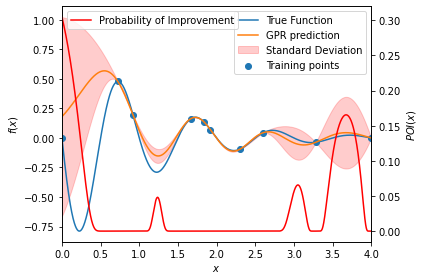

iteration:     6 

Best point found:      (3.6758379189594796, 0.022627793564345276)


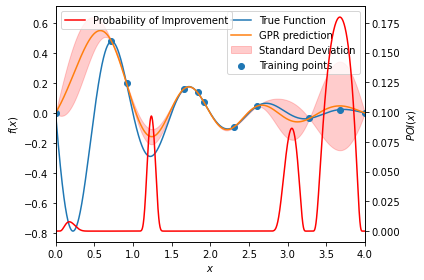

iteration:     7 

Best point found:      (1.2386193096548272, -0.289043490522108)


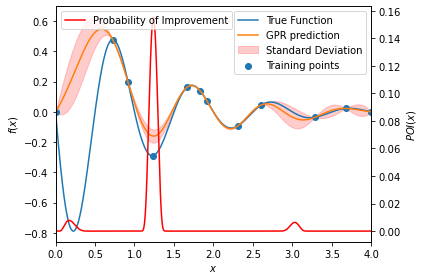

iteration:     8 

Best point found:      (0.21210605302651325, -0.7860597138153108)


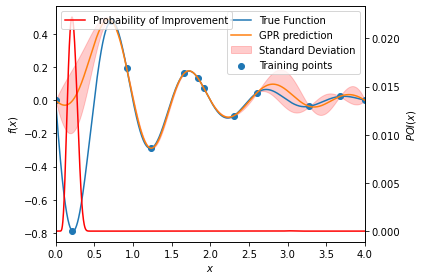

iteration:     9 

Best point found:      (0.288144072036018, -0.7282264183808841)


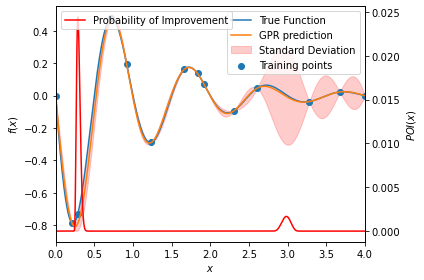

iteration:     10 

Best point found:      (2.9914957478739366, 0.002681755721768946)


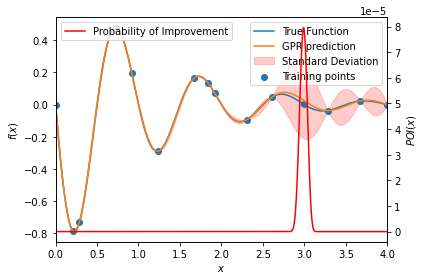

In [22]:
#perform bayesain optimisation for problem 14
Bayesian_optimisation(problem14, 0.0, 4.0, 10, 2000)

iteration:     1 

Best point found:      (4.257128564282141, -6.434569032904724)


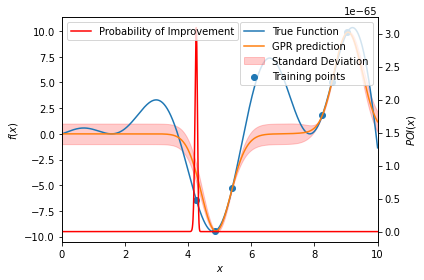

iteration:     2 

Best point found:      (3.221610805402701, 2.9229311155651905)


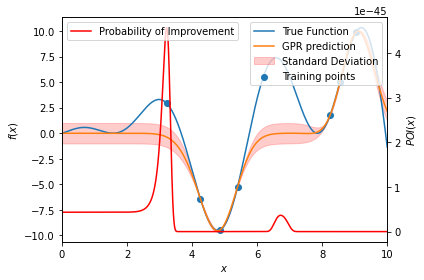

iteration:     3 

Best point found:      (6.648324162081041, 7.326906483263919)


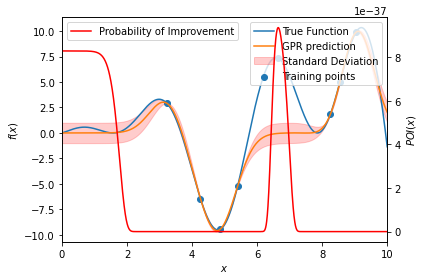

iteration:     4 

Best point found:      (0.0, 0.0)


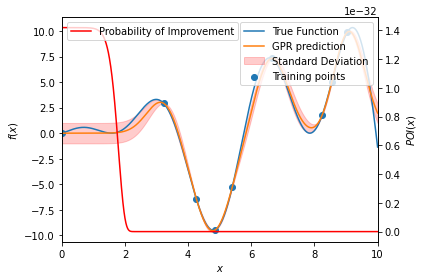

iteration:     5 

Best point found:      (1.3906953476738368, 0.06675330661943124)


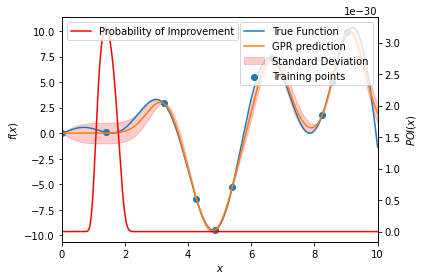

iteration:     6 

Best point found:      (4.622311155577789, -9.151073898881524)


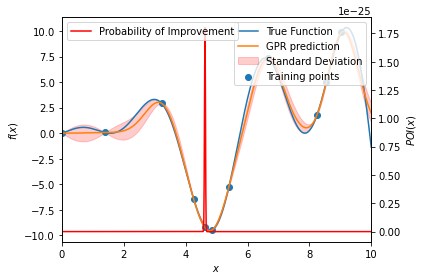

iteration:     7 

Best point found:      (2.2161080540270133, 1.157673869451476)


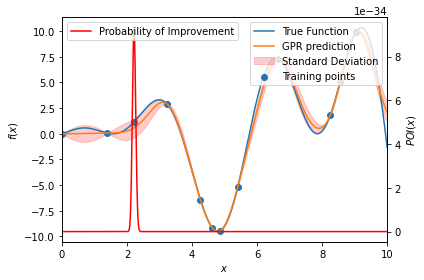

iteration:     8 

Best point found:      (0.6903451725862931, 0.570063796559613)


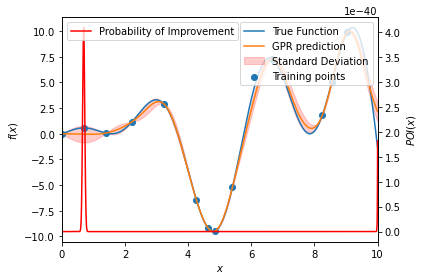

iteration:     9 

Best point found:      (10.0, -1.3593904907597798)


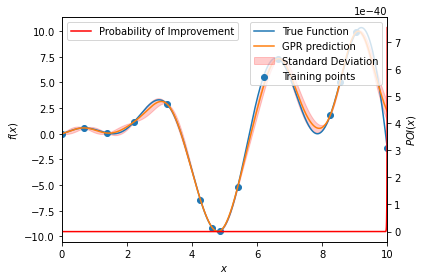

iteration:     10 

Best point found:      (7.503751875937969, 1.3112643298948692)


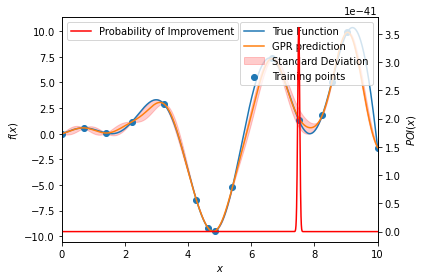

In [23]:
#perform bayesian optimation for problem 21
Bayesian_optimisation(problem21, 0.0, 10.0, 10, 2000)

The GPR prediction becomes better with more iterations - the prediction mathces almost exactly with the 
objective function and standard deviation is largely reduced 

In [24]:
### CW2 - Q2 ###

In [25]:
### Part 1 - Preprocessing

In [26]:
#load patient label data and explore  
labels_df = pd.read_csv('CW2_dataset_PatientID_labels.csv')
labels_df

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


In [27]:
#check numnber of AML and ALL labels 
labels_df['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

Dataset is unbalanced - will need to be accounted for 

In [28]:
#encode categorical data 
labels_df = labels_df.replace({'ALL':0, 'AML':1})

#remove patient column from dataframe 
labels_df = labels_df.drop(columns=['patient'])

#display last 10 rows 
labels_df.tail(10)

,cancer
62,1
63,1
64,1
65,1
66,0
67,0
68,0
69,0
70,0
71,0


In [29]:
#load patient gene data and explore  
data_df = pd.read_csv('CW2_dataset.csv')
data_df

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,72
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214.0,-139,-76,-135.0,-106,-138.0,-72,-413,...,-161,-48,-62,-58,-76,-154,-79,-55,-59,-131
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153.0,-73,-49,-114.0,-125,-85.0,-144,-260,...,-215,-531,-198,-217,-98,-136,-118,-44,-114,-126
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58.0,-1,-307,265.0,-76,215.0,238,7,...,-46,-124,-5,63,-153,49,-30,12,23,-50
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88.0,283,309,12.0,168,71.0,55,-2,...,146,431,141,95,237,180,68,129,146,211
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295.0,-264,-376,-419.0,-230,-272.0,-399,-541,...,-172,-496,-256,-191,-215,-257,-110,-108,-171,-206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793.0,782,1138,627.0,250,645.0,1140,1799,...,809,466,707,423,441,524,742,320,348,874
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329.0,295,777,170.0,314,341.0,482,446,...,445,349,354,41,99,249,234,174,208,393
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36.0,11,41,-50.0,14,26.0,10,59,...,-2,0,-22,0,-8,40,72,-4,0,34
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191.0,76,228,126.0,56,193.0,369,781,...,210,284,260,1777,80,-68,109,176,74,237


In [30]:
#swap x and y axis and remove 'Gene Description','Gene Accession Number' columns 
data_df = data_df.drop(columns=['Gene Description','Gene Accession Number'])
data_df = data_df.T
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214.0,-153.0,-58.0,88.0,-295.0,-558.0,199.0,-176.0,252.0,206.0,...,185.0,511.0,-125.0,389.0,-37.0,793.0,329.0,36.0,191.0,-37.0
2,-139.0,-73.0,-1.0,283.0,-264.0,-400.0,-330.0,-168.0,101.0,74.0,...,169.0,837.0,-36.0,442.0,-17.0,782.0,295.0,11.0,76.0,-14.0
3,-76.0,-49.0,-307.0,309.0,-376.0,-650.0,33.0,-367.0,206.0,-215.0,...,315.0,1199.0,33.0,168.0,52.0,1138.0,777.0,41.0,228.0,-41.0
4,-135.0,-114.0,265.0,12.0,-419.0,-585.0,158.0,-253.0,49.0,31.0,...,240.0,835.0,218.0,174.0,-110.0,627.0,170.0,-50.0,126.0,-91.0
5,-106.0,-125.0,-76.0,168.0,-230.0,-284.0,4.0,-122.0,70.0,252.0,...,156.0,649.0,57.0,504.0,-26.0,250.0,314.0,14.0,56.0,-25.0


In [31]:
#check if there is any categorical data 
data_df.dtypes.value_counts()

float64    7129
dtype: int64

No categorical data to be encoded 

In [32]:
#check for missing values 
data_df.isna().sum().sum()

11

In [33]:
#check for missing values 
data_df.isna().sum().sum()

11

values will need to be imputed 

In [34]:
#split data into test/train sets 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_df, labels_df, test_size=0.33, stratify=labels_df)
#stratify argument to ensure test and train sets are balanced 

In [35]:
#impute missing values 
from sklearn.impute import SimpleImputer

#fit imputer on train data 
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)

#impute values on train data
X_train_array = imp_mean.transform(X_train)
X_train = pd.DataFrame(data=X_train_array)    #convert back to pandas dataframe 

#impute values on test data
X_test_array = imp_mean.transform(X_test)
X_test = pd.DataFrame(data=X_test_array)    #convert back to pandas dataframe 

#check for missing values 
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

0
0


All NaN values dealt with All NaN values dealt with 

In [36]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
count,48.00000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,-108.62500,-151.979167,4.604167,168.020833,-235.229167,-385.020833,-1.604167,-182.187500,71.062500,97.166667,...,167.166667,662.375000,-20.895833,380.062500,-35.291667,723.020833,272.020833,6.520833,359.020833,-30.375000
std,85.67619,87.178342,130.799463,101.125894,128.959212,160.896093,255.356217,104.277587,82.665027,194.128641,...,94.650608,254.571281,87.163148,431.361891,48.597329,474.241679,174.725863,52.456665,599.991400,40.744991
min,-413.00000,-442.000000,-410.000000,-2.000000,-541.000000,-810.000000,-479.000000,-463.000000,-148.000000,-249.000000,...,-58.000000,125.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-207.000000,-33.000000,-190.000000
25%,-140.25000,-209.000000,-76.000000,81.750000,-306.750000,-496.750000,-171.250000,-230.250000,6.000000,-43.750000,...,103.000000,507.500000,-57.250000,195.000000,-62.000000,429.000000,172.250000,-11.250000,106.750000,-46.750000
50%,-99.00000,-143.000000,-6.000000,170.000000,-216.500000,-395.000000,-29.500000,-152.500000,67.500000,98.500000,...,171.000000,632.500000,-13.500000,255.000000,-30.500000,645.500000,263.500000,8.500000,183.500000,-27.500000
75%,-55.75000,-94.750000,52.500000,241.500000,-149.750000,-245.750000,168.250000,-115.000000,136.000000,206.500000,...,213.250000,816.750000,35.250000,445.250000,-3.500000,815.250000,355.250000,28.500000,319.500000,-11.750000
max,17.00000,-13.000000,312.000000,396.000000,114.000000,-122.000000,709.000000,-11.000000,252.000000,524.000000,...,409.000000,1455.000000,218.000000,2527.000000,42.000000,2315.000000,906.000000,115.000000,3193.000000,78.000000


In [37]:
#scale data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#standardise data
scaler = StandardScaler()
scaler.fit(X_train)     #fit scaler using training data 

#scale training data 
train_data_array = scaler.transform(X_train)
X_train = pd.DataFrame(data=train_data_array)    #convert back to pandas dataframe 

#scale testing data 
test_data_array = scaler.transform(X_test)
X_test = pd.DataFrame(data=test_data_array)    #convert back to pandas dataframe 

X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
count,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,...,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01,4.800000e+01
mean,2.312965e-17,-1.202742e-16,-1.026378e-17,-1.017704e-16,-1.017704e-16,-1.263457e-16,-2.775558e-17,5.782412e-18,-3.469447e-18,-6.967806e-17,...,1.161542e-16,-6.938894e-18,-4.857226e-17,1.676899e-17,-7.748432e-17,-1.127570e-16,8.037552e-17,4.915050e-18,3.932040e-17,-2.312965e-17
std,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,...,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00,1.010582e+00
min,-3.590216e+00,-3.361958e+00,-3.203313e+00,-1.699071e+00,-2.396158e+00,-2.669278e+00,-1.889313e+00,-2.721430e+00,-2.678045e+00,-1.802052e+00,...,-2.404099e+00,-2.133240e+00,-3.178004e+00,-9.466261e-01,-3.841013e+00,-1.397943e+00,-1.816239e+00,-4.113498e+00,-6.602917e-01,-3.959117e+00
25%,-3.730286e-01,-6.609927e-01,-6.227636e-01,-8.621311e-01,-5.604694e-01,-7.017667e-01,-6.713801e-01,-4.657867e-01,-7.953909e-01,-7.335749e-01,...,-6.851060e-01,-6.148138e-01,-4.214955e-01,-4.335591e-01,-5.554003e-01,-6.265418e-01,-5.770562e-01,-3.423567e-01,-4.249068e-01,-4.061428e-01
50%,1.135304e-01,1.040876e-01,-8.192987e-02,1.977842e-02,1.467702e-01,-6.267877e-02,-1.103989e-01,2.877096e-01,-4.355166e-02,6.940980e-03,...,4.092841e-02,-1.185960e-01,8.574837e-02,-2.929928e-01,9.964279e-02,-1.651925e-01,-4.928294e-02,3.812882e-02,-2.956347e-01,7.130752e-02
75%,6.236802e-01,6.634077e-01,3.700526e-01,7.343000e-01,6.698531e-01,8.747549e-01,6.722046e-01,6.511322e-01,7.938628e-01,5.691604e-01,...,4.920307e-01,6.128289e-01,6.509630e-01,1.527194e-01,6.611083e-01,1.965352e-01,4.813822e-01,4.234306e-01,-6.656605e-02,4.619487e-01
max,1.481793e+00,1.611064e+00,2.375000e+00,2.278266e+00,2.736717e+00,1.652024e+00,2.812244e+00,1.659024e+00,2.211966e+00,2.221981e+00,...,2.582049e+00,3.146517e+00,2.769793e+00,5.029784e+00,1.607282e+00,3.392418e+00,3.666819e+00,2.089861e+00,4.773350e+00,2.687983e+00


In [38]:
print('X_train shape:    ', X_train.shape)
print('X_test shape:    ', X_test.shape)
print('y_train shape:    ', y_train.shape)
print('y_test shape:    ', y_test.shape, '\n')

print('y_train labels',    y_train.value_counts())
print('y_test labels',    y_test.value_counts())

X_train shape:     (48, 7129)
X_test shape:     (24, 7129)
y_train shape:     (48, 1)
y_test shape:     (24, 1) 

y_train labels cancer
0         31
1         17
dtype: int64
y_test labels cancer
0         16
1          8
dtype: int64


In [39]:
### Part 2 - Feature Extraction 

In [40]:
y_train = y_train.to_numpy().reshape(len(y_train),) #reshape y_train for sklearn functions 

In [41]:
from sklearn.feature_selection import SelectKBest, f_classif

#define feature selector and fit to training data 
feature_selector = SelectKBest(score_func=f_classif, k=8)    #optimal number of features appears to be around this value
feature_selector.fit(X_train, y_train)

#transform test and train data 
X_train_reduced_array = feature_selector.transform(X_train)
X_train_reduced = pd.DataFrame(data=X_train_reduced_array)

X_test_reduced_array = feature_selector.transform(X_test)
X_test_reduced = pd.DataFrame(data=X_test_reduced_array)

In [42]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(48, 8)
(24, 8)


In [43]:
### Part 3 - Supervised Classification 

In [44]:
#import relevant packages 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

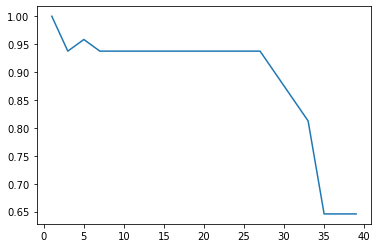

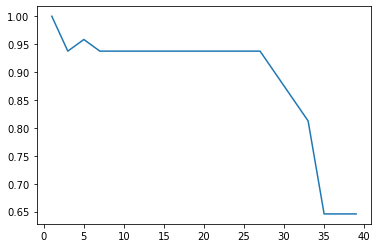

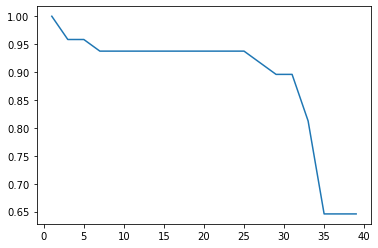

In [94]:
#build KNN model 

#test different numbers of nearest neighbours for euclidean distance metric 
k_vals = np.arange(1,41,2)
accuracy_vals = np.zeros_like(k_vals, dtype=float)

for i in range(len(k_vals)):
    k = k_vals[i]
    
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn.fit(X_train_reduced, y_train)
    
    acc = knn.score(X_train_reduced, y_train)
    accuracy_vals[i] = acc
    
plt.plot(k_vals, accuracy_vals)
plt.show()

#test different numbers of nearest neighbours for minkowski distance metric 
k_vals = np.arange(1,41,2)
accuracy_vals = np.zeros_like(k_vals, dtype=float)

for i in range(len(k_vals)):
    k = k_vals[i]
    
    knn = KNeighborsClassifier(n_neighbors=k, metric="minkowski")
    knn.fit(X_train_reduced, y_train)
    
    acc = knn.score(X_train_reduced, y_train)
    accuracy_vals[i] = acc
    
plt.plot(k_vals, accuracy_vals)
plt.show()

#test different numbers of nearest neighbours for manhattan distance metric 
k_vals = np.arange(1,41,2)
accuracy_vals = np.zeros_like(k_vals, dtype=float)

for i in range(len(k_vals)):
    k = k_vals[i]
    
    knn = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    knn.fit(X_train_reduced, y_train)
    
    acc = knn.score(X_train_reduced, y_train)
    accuracy_vals[i] = acc
    
plt.plot(k_vals, accuracy_vals)
plt.show()

tests indicate that k=1 is optimal number of nearest neighbours 

In [95]:
#use grid search CV to test other hyperparameters for KNN model 

grid_params_knn = {
    'n_neighbors': [1,3,5,7,9,11],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski','mahalanobis']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, grid_params_knn, verbose=1, n_jobs=-1, cv=10, scoring='accuracy')

grid_search_knn.fit(X_train_reduced, y_train)

print('Best parameters: ', grid_search_knn.best_params_)
print('Best accuracy:   ', grid_search_knn.best_score_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best parameters:  {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best accuracy:    0.9349999999999999


KNN model accuracy:     0.9166666666666666


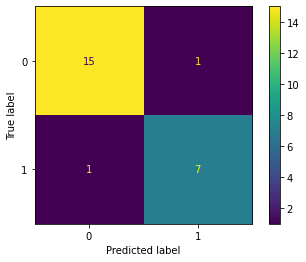

In [96]:
#train KNN model and predict labels using best params from gridsearchcv

knn_actual = KNeighborsClassifier(n_neighbors=1, algorithm='auto', metric='euclidean', weights='uniform')
knn_actual.fit(X_train_reduced, y_train)
y_pred_knn = knn_actual.predict(X_test_reduced)

knn_actual_accuracy = knn_actual.score(X_test_reduced, y_test)
print('KNN model accuracy:    ', knn_actual_accuracy)

knn_actual_cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(knn_actual_cm).plot()

In [97]:
# KNN model classification report 
print(classification_report(y_test, y_pred_knn, target_names=['ALL','AML']))

              precision    recall  f1-score   support

         ALL       0.94      0.94      0.94        16
         AML       0.88      0.88      0.88         8

    accuracy                           0.92        24
   macro avg       0.91      0.91      0.91        24
weighted avg       0.92      0.92      0.92        24



[]

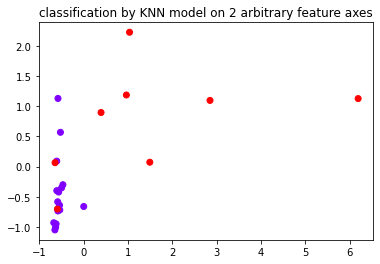

In [98]:
plt.scatter(X_test_reduced.to_numpy()[:,2], X_test_reduced.to_numpy()[:,5], c=y_pred_knn, cmap='rainbow')
plt.title('classification by KNN model on 2 arbitrary feature axes')
plt.plot()

In [50]:
#build SVM model 

#test different hyperparams using gridsearchCV
grid_params_svm = {
    'C': [0.01,0.1,1.0,10.0,100.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.001,0.01,0.1,1.0,10.0],
    'decision_function_shape': ['ovo', 'ovr']
    }

svm = SVC()
grid_search_svm = GridSearchCV(svm, grid_params_svm, verbose=1, n_jobs=-1, cv=10, scoring='accuracy')

grid_search_svm.fit(X_train_reduced, y_train)

print('Best parameters: ', grid_search_svm.best_params_)
print('Best accuracy:   ', grid_search_svm.best_score_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best parameters:  {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 10.0, 'kernel': 'sigmoid'}
Best accuracy:    0.975


SVM model accuracy:     0.875


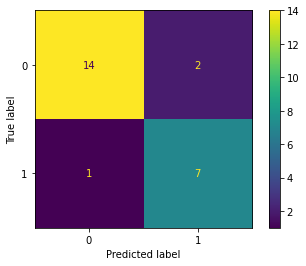

In [99]:
#train SVM model and predict labels using best params from gridsearchcv

svm_actual = SVC(C=0.1, decision_function_shape='ovo', gamma=10.0, kernel='sigmoid')
svm_actual.fit(X_train_reduced, y_train)
y_pred_svm = svm_actual.predict(X_test_reduced)

svm_actual_accuracy = svm_actual.score(X_test_reduced, y_test)
print('SVM model accuracy:    ', svm_actual_accuracy)

svm_actual_cm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(svm_actual_cm).plot()

In [100]:
# SVM model classification report 
print(classification_report(y_test, y_pred_svm, target_names=['ALL','AML']))

              precision    recall  f1-score   support

         ALL       0.93      0.88      0.90        16
         AML       0.78      0.88      0.82         8

    accuracy                           0.88        24
   macro avg       0.86      0.88      0.86        24
weighted avg       0.88      0.88      0.88        24



[]

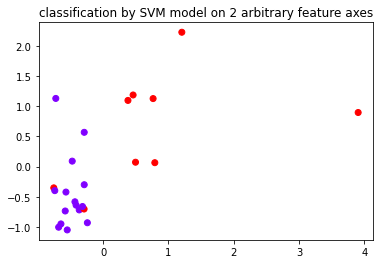

In [101]:
plt.scatter(X_test_reduced.to_numpy()[:,1], X_test_reduced.to_numpy()[:,5], c=y_pred_svm, cmap='rainbow')
plt.title('classification by SVM model on 2 arbitrary feature axes')
plt.plot()

In [54]:
### Part 4 - Summary and discussion

With this test/train split the results for the KNN and SVM model are very similar but the KNN model performs slightly better. On other runs with different splits the results have been very similar.  It cannot be said that one model is significantly better than the other. It appears both models can predict the type of cancer to a high degree of accuracy and precision. The false negative rate and false positive rate was extremely low. 

A number of factors could affect these results, however, it seems that the feature 
selection had the greatest impact. A large deviation from the selected number of features, k=8, had negative 
comsequences for the performance of the two models. The SVM model appeared to handle more features slightly better
than the KNN model.

Further analysis into the feature selection should improve performance of both models. Tree based feature selection
would be a good method to attmept.

In [55]:
### CW2 Q3 ###

In [56]:
### part 1 - Preprocessing 

In [57]:
#upload data 
data_df = pd.read_csv('CW2_dataset.csv')
data_df

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,72
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214.0,-139,-76,-135.0,-106,-138.0,-72,-413,...,-161,-48,-62,-58,-76,-154,-79,-55,-59,-131
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153.0,-73,-49,-114.0,-125,-85.0,-144,-260,...,-215,-531,-198,-217,-98,-136,-118,-44,-114,-126
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58.0,-1,-307,265.0,-76,215.0,238,7,...,-46,-124,-5,63,-153,49,-30,12,23,-50
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88.0,283,309,12.0,168,71.0,55,-2,...,146,431,141,95,237,180,68,129,146,211
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295.0,-264,-376,-419.0,-230,-272.0,-399,-541,...,-172,-496,-256,-191,-215,-257,-110,-108,-171,-206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793.0,782,1138,627.0,250,645.0,1140,1799,...,809,466,707,423,441,524,742,320,348,874
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329.0,295,777,170.0,314,341.0,482,446,...,445,349,354,41,99,249,234,174,208,393
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36.0,11,41,-50.0,14,26.0,10,59,...,-2,0,-22,0,-8,40,72,-4,0,34
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191.0,76,228,126.0,56,193.0,369,781,...,210,284,260,1777,80,-68,109,176,74,237


In [58]:
#swap x and y axis and remove 'Gene Description','Gene Accession Number' columns 
data_df = data_df.drop(columns=['Gene Description','Gene Accession Number'])
data_df = data_df.T
data_df 

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214.0,-153.0,-58.0,88.0,-295.0,-558.0,199.0,-176.0,252.0,206.0,...,185.0,511.0,-125.0,389.0,-37.0,793.0,329.0,36.0,191.0,-37.0
2,-139.0,-73.0,-1.0,283.0,-264.0,-400.0,-330.0,-168.0,101.0,74.0,...,169.0,837.0,-36.0,442.0,-17.0,782.0,295.0,11.0,76.0,-14.0
3,-76.0,-49.0,-307.0,309.0,-376.0,-650.0,33.0,-367.0,206.0,-215.0,...,315.0,1199.0,33.0,168.0,52.0,1138.0,777.0,41.0,228.0,-41.0
4,-135.0,-114.0,265.0,12.0,-419.0,-585.0,158.0,-253.0,49.0,31.0,...,240.0,835.0,218.0,174.0,-110.0,627.0,170.0,-50.0,126.0,-91.0
5,-106.0,-125.0,-76.0,168.0,-230.0,-284.0,4.0,-122.0,70.0,252.0,...,156.0,649.0,57.0,504.0,-26.0,250.0,314.0,14.0,56.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-154.0,-136.0,49.0,180.0,-257.0,-273.0,141.0,-123.0,52.0,878.0,...,214.0,540.0,13.0,1075.0,-45.0,524.0,249.0,40.0,-68.0,-1.0
69,-79.0,-118.0,-30.0,68.0,-110.0,-264.0,-28.0,-61.0,40.0,-217.0,...,409.0,617.0,-34.0,738.0,11.0,742.0,234.0,72.0,109.0,-30.0
70,-55.0,-44.0,12.0,129.0,-108.0,-301.0,-222.0,-133.0,136.0,320.0,...,131.0,318.0,35.0,241.0,-66.0,320.0,174.0,-4.0,176.0,40.0
71,-59.0,-114.0,23.0,146.0,-171.0,-227.0,-73.0,-126.0,-6.0,149.0,...,214.0,760.0,-38.0,201.0,-55.0,348.0,208.0,0.0,74.0,-12.0


In [59]:
#check for missing values 
data_df.isna().sum().sum()

11

Need to impute values 

In [60]:
#import sklearn package for imputation  
from sklearn.impute import SimpleImputer

#fit imputer on data 
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data_df)

#impute values
imputed_data_array = imp_mean.transform(data_df)
data_df = pd.DataFrame(data=imputed_data_array)    #convert back to pandas dataframe

In [61]:
#check again for missing values 
data_df.isna().sum().sum()

0

In [62]:
#describe data 
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.00000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,-114.583333,-160.125000,-8.069444,189.347222,-253.305556,-396.125000,-64.777778,-190.694444,80.083333,98.194444,...,175.347222,668.37500,-11.750000,381.805556,-33.666667,780.555556,303.944444,9.569444,433.486111,-30.569444
std,97.738333,96.136631,122.697995,111.884014,122.183611,150.291354,284.700199,99.886645,89.409447,227.277868,...,94.134031,305.72336,87.403347,378.516029,52.052249,451.249904,206.500137,44.874732,623.918444,40.192434
min,-476.000000,-531.000000,-410.000000,-36.000000,-541.000000,-810.000000,-1038.000000,-463.000000,-148.000000,-468.000000,...,-58.000000,91.00000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-207.000000,-68.000000,-190.000000
25%,-148.000000,-213.500000,-77.250000,99.500000,-344.250000,-501.250000,-221.250000,-237.750000,6.000000,-58.500000,...,112.000000,462.50000,-53.500000,200.000000,-63.000000,519.000000,173.750000,-8.000000,123.500000,-54.750000
50%,-100.500000,-144.000000,-14.000000,179.000000,-227.500000,-394.000000,-57.500000,-175.000000,77.500000,98.500000,...,173.000000,632.50000,3.000000,286.000000,-24.500000,701.500000,295.000000,9.500000,218.000000,-28.500000
75%,-57.500000,-96.750000,49.000000,277.750000,-173.500000,-281.750000,87.250000,-121.250000,140.250000,213.500000,...,225.000000,823.00000,45.250000,456.750000,2.500000,1016.000000,386.500000,29.500000,373.000000,-3.750000
max,86.000000,-13.000000,312.000000,431.000000,114.000000,-122.000000,709.000000,-11.000000,283.000000,878.000000,...,413.000000,1653.00000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,78.000000


In [63]:
#scale data - standardise 
#import sklearn to standardise data  
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_df)

#scale training data 
scaled_data_array = scaler.transform(data_df)
data_df = pd.DataFrame(data=scaled_data_array)    #convert back to pandas dataframe 

In [64]:
#check to make sure data is standardised 
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,...,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,-4.703028e-17,1.541976e-17,3.854941e-17,-7.748432e-17,-6.553400e-17,-4.009139e-17,-1.811822e-17,9.560254e-17,4.047688e-17,-3.083953e-17,...,-6.938894e-17,5.782412e-17,1.310680e-17,6.167906e-18,-9.868649e-17,2.737008e-17,-6.167906e-17,-5.242720e-17,6.399202e-17,-7.709882e-17
std,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,...,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,-3.723748e+00,-3.884863e+00,-3.298759e+00,-2.028249e+00,-2.371131e+00,-2.773143e+00,-3.442400e+00,-2.745277e+00,-2.568900e+00,-2.508682e+00,...,-2.496279e+00,-1.901807e+00,-3.263465e+00,-1.079620e+00,-3.604858e+00,-1.592384e+00,-1.687031e+00,-4.859957e+00,-8.094092e-01,-3.994518e+00
25%,-3.442986e-01,-5.590956e-01,-5.677847e-01,-8.086744e-01,-7.495495e-01,-7.043834e-01,-5.534604e-01,-4.743955e-01,-8.343998e-01,-6.942782e-01,...,-6.776696e-01,-6.781286e-01,-4.810226e-01,-4.836820e-01,-5.674910e-01,-5.836922e-01,-6.349056e-01,-3.942695e-01,-5.003242e-01,-6.058415e-01
50%,1.451034e-01,1.689071e-01,-4.867377e-02,-9.313069e-02,2.126852e-01,1.423843e-02,2.574234e-02,1.582252e-01,-2.909606e-02,1.353849e-03,...,-2.510988e-02,-1.181681e-01,1.699421e-01,-2.548845e-01,1.773409e-01,-1.764218e-01,-4.361844e-02,-1.558378e-03,-3.477992e-01,5.184974e-02
75%,5.881410e-01,6.638442e-01,4.683853e-01,7.956736e-01,6.577445e-01,7.663624e-01,5.377399e-01,7.001114e-01,6.776565e-01,5.108932e-01,...,5.311705e-01,5.093170e-01,6.567255e-01,1.993849e-01,6.996906e-01,5.254222e-01,4.025900e-01,4.472544e-01,-9.762587e-02,6.719586e-01
max,2.066650e+00,1.541114e+00,2.626902e+00,2.175008e+00,3.027273e+00,1.836757e+00,2.736942e+00,1.811608e+00,2.285448e+00,3.455145e+00,...,2.542338e+00,3.243242e+00,2.647065e+00,5.707152e+00,1.657332e+00,3.424295e+00,3.925930e+00,2.365929e+00,4.453914e+00,2.720197e+00


In [65]:
#PCA method of dimensionality reduction to remove noise 

#import sklearn package for PCA 
from sklearn.decomposition import PCA

pca = PCA(0.90)    #choose number of components that explains 80% of variance 
pca.fit(data_df)    #fit transformer to data  

#transform training set 
transformed_array = pca.transform(data_df)
data_df = pd.DataFrame(data=transformed_array)    #convert back to pandas dataframe 

In [66]:
print('Shape of reduced data matrix:   ', data_df.shape)
print('Explained variance ratio for each component:   ', pca.explained_variance_ratio_)
print('Total variance explained:   ', sum(pca.explained_variance_ratio_))
print('Variance explained by first 3 components:   ', sum(pca.explained_variance_ratio_[:3]))

Shape of reduced data matrix:    (72, 51)
Explained variance ratio for each component:    [0.14921055 0.0944667  0.04670337 0.04035469 0.03428032 0.0318835
 0.02707086 0.02420011 0.02210582 0.02149822 0.01875559 0.01821352
 0.01675435 0.01565263 0.01539483 0.01430419 0.01364692 0.01260937
 0.01245301 0.01177899 0.01169755 0.01135417 0.0108513  0.01067239
 0.01047303 0.01041113 0.00973055 0.00962684 0.00949891 0.00913463
 0.00902308 0.00887923 0.00883377 0.00850606 0.00838348 0.00811826
 0.00794762 0.00793225 0.00784317 0.00754264 0.00741764 0.00729082
 0.00724104 0.00702984 0.00695379 0.00688088 0.00679833 0.00676172
 0.0065724  0.00649222 0.00622581]
Total variance explained:    0.9034620828507458
Variance explained by first 3 components:    0.2903806118513676


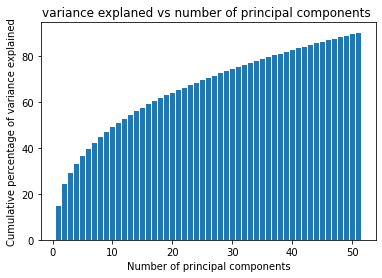

In [67]:
var_exp = (pca.explained_variance_ratio_).cumsum()*100.
n_components = len(var_exp)
n = np.arange(1,n_components+1)
plt.bar(n,var_exp)
plt.title('variance explaned vs number of principal components ')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative percentage of variance explained')
plt.show()

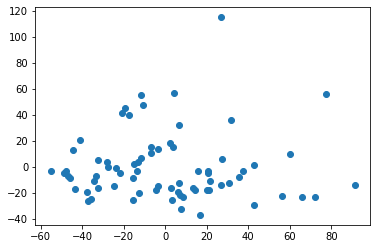

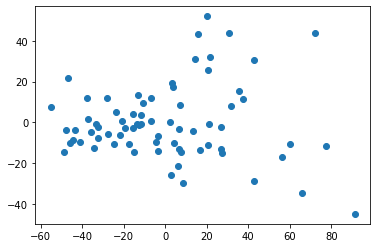

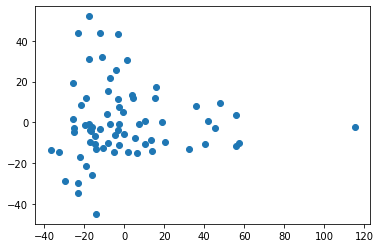

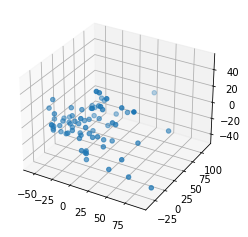

In [68]:
#visualise distribution of the first 3 principal components 

#2d graphs 
plt.scatter(data_df.to_numpy()[:,0], data_df.to_numpy()[:,1])
plt.show()

plt.scatter(data_df.to_numpy()[:,0], data_df.to_numpy()[:,2])
plt.show()

plt.scatter(data_df.to_numpy()[:,1], data_df.to_numpy()[:,2])
plt.show()

#3d graph
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data_df.to_numpy()[:,0],data_df.to_numpy()[:,1],data_df.to_numpy()[:,2]);

In [69]:
#relabel processed data matrix
X = data_df

In [70]:
#define truth class labels for future use 

#load label data
labels_df = pd.read_csv('CW2_dataset_PatientID_labels.csv')
#encode categorical data 
labels_df = labels_df.replace({'ALL':0, 'AML':1})
#extract cancer labels
y_true = labels_df['cancer'].to_numpy()

In [71]:
### Part 2 - K-means clustering 

In [72]:
#import kmeans clustering package 
from sklearn.cluster import KMeans

In [73]:
#define function to train kmeans model 
def kmeans_model(X, K):
    '''
    ### INPUT ###
    X:        feature matrix
    K:        number of clusters 
    
    ### OUTPUT ### 
    cluster_centers:    centroids of clusters
    y_pred:             predicted labels of data points 
    '''
    Kmean = KMeans(n_clusters=K)
    Kmean.fit_predict(X)
    
    #data to return 
    cluster_centers = Kmean.cluster_centers_
    y_pred = Kmean.labels_
    
    return cluster_centers, y_pred

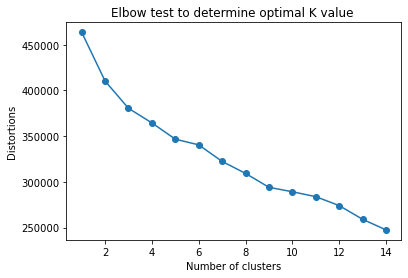

In [74]:
#use elbow method to find optimal cluster number, K

cluster_vals = np.arange(1,15)        #number of clusters  to try 
distortion_vals = np.zeros_like(cluster_vals, dtype=float)

for i in range(len(cluster_vals)):
    
    K = cluster_vals[i]
    kmeans = KMeans(n_clusters=K)
    kmeans.fit_predict(X)
    
    distortion = kmeans.inertia_
    distortion_vals[i] = distortion
    
plt.plot(cluster_vals, distortion_vals, marker='o')
plt.title('Elbow test to determine optimal K value ')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.show()

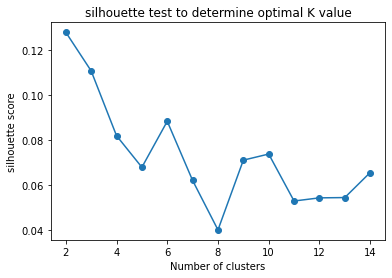

In [75]:
#silhouette method to find optimal cluster number, K

#import silhouette score package 
from sklearn.metrics import silhouette_score

cluster_vals = np.arange(2,15)    #number of clusters paramters to try - dissimilarity not defined for single cluster 
sil_vals = np.zeros_like(cluster_vals, dtype=float)

for i in range(len(cluster_vals)):
    
    K = cluster_vals[i]
    kmeans = KMeans(n_clusters=K)
    kmeans.fit_predict(X)
    labels = kmeans.labels_
    
    sil = silhouette_score(X, labels, metric = 'euclidean')
    sil_vals[i] = sil
    
plt.plot(cluster_vals, sil_vals, marker='o')
plt.title('silhouette test to determine optimal K value')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.show()

elbow test and silhouette test imply the optimal number of clusters is K=2

In [76]:
#run Kmeans model for K=2
cluster_centers, y_pred_kmeans = kmeans_model(X, K=2)

In [77]:
cluster_centers

array([[ 3.28502123e+01, -9.89905374e+00,  4.32485194e+00,
        -2.94975517e-01, -6.17697779e-01,  2.64002724e+00,
         1.66397606e+00,  5.71214015e-01, -9.65530612e-01,
         3.31487448e-01,  6.72190447e-01, -4.66548494e-01,
         1.14916757e+00, -8.53619306e-01,  2.00011086e+00,
         1.61043177e+00, -1.51046604e-01,  6.54457320e-01,
        -5.21366449e-02,  5.85108742e-01, -1.03687143e+00,
         3.40185017e-01, -1.12985191e+00,  3.70016065e-01,
         1.34134473e+00,  6.61871051e-01, -1.05923475e-01,
         7.06887203e-01,  1.74168922e-01, -5.76827493e-01,
        -1.34934165e+00, -7.27958910e-01, -8.01390965e-01,
        -2.81737332e-01,  1.85695223e+00, -5.34020731e-01,
         3.20934562e-01, -2.62301727e-01, -4.69432144e-01,
         1.28829760e-01,  3.35614877e-01,  2.99677653e-02,
        -1.06080835e-01,  8.62654822e-01, -7.63159786e-01,
         7.11777274e-02, -6.73606107e-01, -4.42263822e-01,
        -8.38682221e-01, -5.57251770e-01,  1.08089819e-0

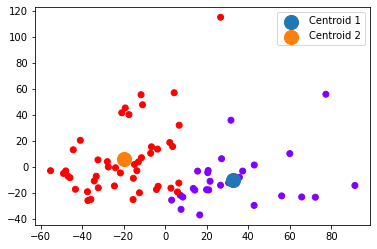

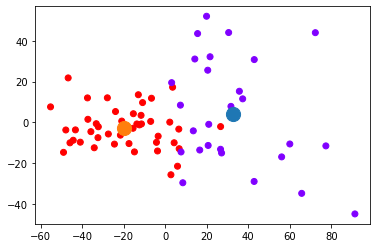

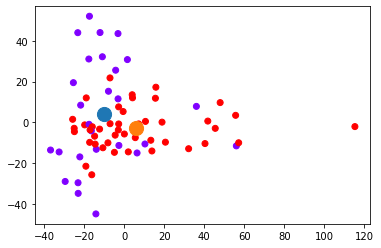

In [78]:
#visualise centroid and clustering results 

#2d graphs 
#principal component 1 vs principal component 2
plt.scatter(data_df.to_numpy()[:,0], data_df.to_numpy()[:,1], c=y_pred_kmeans, cmap='rainbow')
plt.scatter(cluster_centers[0][0], cluster_centers[0][1], s=200, label='Centroid 1')    #centroid 1
plt.scatter(cluster_centers[1][0], cluster_centers[1][1], s=200, label='Centroid 2')    #centroid 2
plt.legend()
plt.show()

#principal component 1 vs principal component 3
plt.scatter(data_df.to_numpy()[:,0], data_df.to_numpy()[:,2], c=y_pred_kmeans, cmap='rainbow')
plt.scatter(cluster_centers[0][0], cluster_centers[0][2], s=200)    #centroid 1
plt.scatter(cluster_centers[1][0], cluster_centers[1][2], s=200)    #centroid 2
plt.show()

#principal component 2 vs principal component 3
plt.scatter(data_df.to_numpy()[:,1], data_df.to_numpy()[:,2], c=y_pred_kmeans, cmap='rainbow')
plt.scatter(cluster_centers[0][1], cluster_centers[0][2], s=200)    #centroid 1
plt.scatter(cluster_centers[1][1], cluster_centers[1][2], s=200)    #centroid 2
plt.show()

In [79]:
### Part 3 - Hierarchical clustering 

In [80]:
#import hierarchical package 
from sklearn.cluster import AgglomerativeClustering

In [81]:
#define fucntion for Hierarchical clustering
def HCluster_model(X, n_clusters, affinity, linkage):
    '''
    ### INPUT ###
    X:               feature matrix
    n_clusters:      number of clusters 
    affinity:   
    linkage:   
    
    ### OUTPUT ### 
    y_pred:          predicted labels of data points 
    '''
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    y_pred = cluster.fit_predict(X)
    
    return y_pred

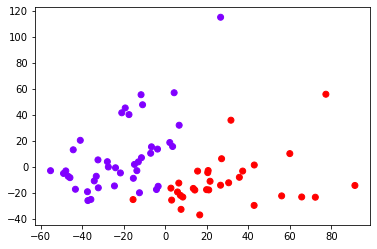

In [82]:
n_clusters=2
affinity='euclidean'
linkage='ward'

y_pred_hclus = HCluster_model(X, n_clusters, affinity, linkage)

plt.scatter(X.to_numpy()[:,0],X.to_numpy()[:,1], c=y_pred_hclus, cmap='rainbow')
plt.show()

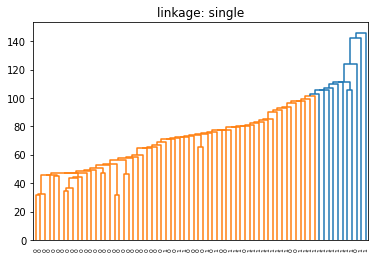

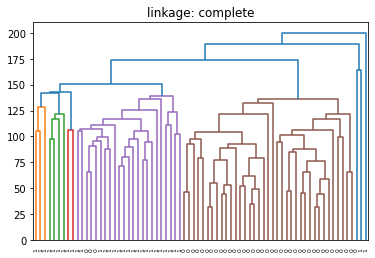

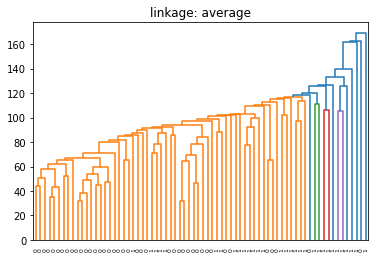

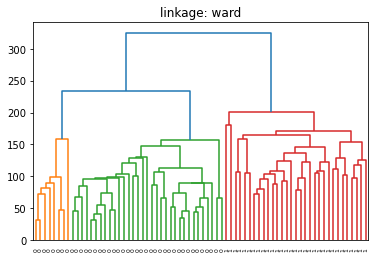

In [83]:
#plot dendrograms
#show effect of different linkage on cluesterin results 

from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, 'single')
labelList = y_pred_hclus
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
plt.title('linkage: single')
plt.show()

linked = linkage(X, 'complete')
labelList = y_pred_hclus
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
plt.title('linkage: complete')
plt.show()

linked = linkage(X, 'average')
labelList = y_pred_hclus
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
plt.title('linkage: average')
plt.show()

linked = linkage(X, 'ward')
labelList = y_pred_hclus
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
plt.title('linkage: ward')
plt.show()

In [84]:
#import validity indices packages
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score

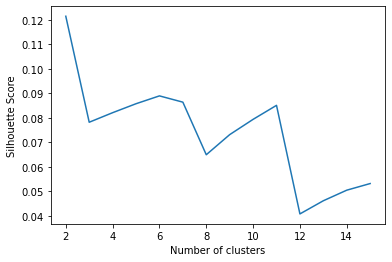

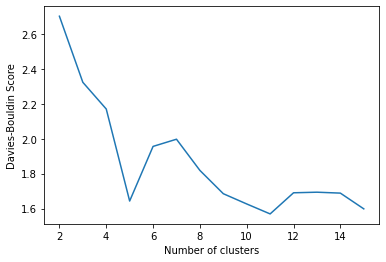

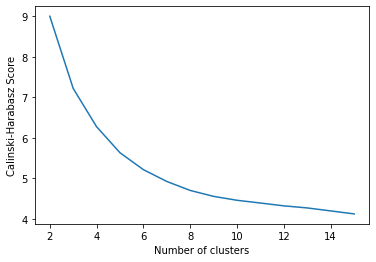

In [85]:
#initialise arrays for number of clusters and for validation indices
cluster_vals = np.arange(2,16)
SI_vals = np.zeros_like(cluster_vals, dtype=float)
DBI_vals = np.zeros_like(cluster_vals, dtype=float)
CH_vals = np.zeros_like(cluster_vals, dtype=float)

#define necessary variables 
X=data_df
affinity='euclidean'
linkage='ward'

#main loop
for i in range(len(cluster_vals)):
    
    n_clusters = cluster_vals[i]
    labels = HCluster_model(X, n_clusters, affinity, linkage)
    
    #validation indices values 
    SI_vals[i] = silhouette_score(X, labels)
    DBI_vals[i] = davies_bouldin_score(X, labels)
    CH_vals[i] = calinski_harabasz_score(X, labels)
    
#plot indices vs cluster number 
plt.plot(cluster_vals,SI_vals)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

plt.plot(cluster_vals,DBI_vals)
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

plt.plot(cluster_vals,CH_vals)
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

Silhouette Score and Calinski-Harabasz Score suggest optimal number of clusters is 2.
A lower Davies-Bouldin Score corresponds to a model with better seperation between clusters. Therefore
this test suggests the more clusters the better. Clearly this does not seem reasonable as it suggests 
the optimal number of clusters is 15.

These internal validation indices suggest the optimal number of clusters is 2

In [86]:
### Part 4 - summary and discussion 

In [87]:
n_clusters=2
affinity='euclidean'
linkage='ward'

#define kmeans model 
cluster_centers, y_pred_kmeans = kmeans_model(X, K=n_clusters)

#define hierarchcial clustermodel
y_pred_hclus = HCluster_model(X, n_clusters, affinity, linkage)

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn import metrics 

KMeans Rand score:     0.5809859154929577
HCluster Rand score:     0.6197183098591549 

Adjusted KMeans Rand score:     0.16207751501386602
Adjusted HCluster Rand score:     0.2391007268938473 

KMeans mutual information score:     0.08350021446465455
HCluster mutual information score:     0.12127818003164209 

KMeans fowlkes mallows score:     0.5973804570823781
HCluster fowlkes mallows score:     0.6358212041489018 

KMeans pair confusion matrix:     [[1384  966]
 [1176 1586]]
HCluster pair confusion matrix:     [[1474  876]
 [1068 1694]] 



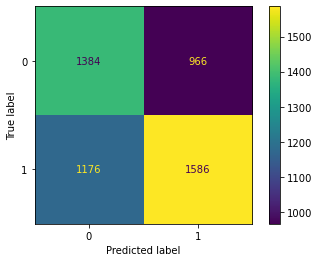

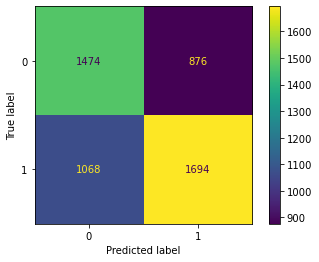

In [91]:
#external validation indices 

#rand score 
kmeans_rand = metrics.rand_score(y_true, y_pred_kmeans)
hcluster_rand = metrics.rand_score(y_true, y_pred_hclus)

#adjusted rand score 
adj_kmeans_rand = metrics.adjusted_rand_score(y_true, y_pred_kmeans)
adj_hcluster_rand = metrics.adjusted_rand_score(y_true, y_pred_hclus)

#mutual information score
kmeans_minfo = metrics.mutual_info_score(y_true, y_pred_kmeans)
hcluster_minfo = metrics.mutual_info_score(y_true, y_pred_hclus)

#fowlkes mallows score
kmeans_fms = metrics.fowlkes_mallows_score(y_true, y_pred_kmeans)
hcluster_fms = metrics.fowlkes_mallows_score(y_true, y_pred_hclus)

#Pair confusion matrix 
kmeans_conf_matrix = pair_confusion_matrix(y_true, y_pred_kmeans)
hcluster_conf_matrix = pair_confusion_matrix(y_true, y_pred_hclus)


# print(y_true)
# print(kmeans_labels)
# print(hcluster_labels)

#print scores 
print('KMeans Rand score:    ', kmeans_rand)
print('HCluster Rand score:    ', hcluster_rand, '\n')

print('Adjusted KMeans Rand score:    ', adj_kmeans_rand)
print('Adjusted HCluster Rand score:    ', adj_hcluster_rand, '\n')

print('KMeans mutual information score:    ', kmeans_minfo)
print('HCluster mutual information score:    ', hcluster_minfo, '\n')

print('KMeans fowlkes mallows score:    ', kmeans_fms)
print('HCluster fowlkes mallows score:    ', hcluster_fms, '\n')

print('KMeans pair confusion matrix:    ', kmeans_conf_matrix)
ConfusionMatrixDisplay(kmeans_conf_matrix).plot()
print('HCluster pair confusion matrix:    ', hcluster_conf_matrix, '\n')
ConfusionMatrixDisplay(hcluster_conf_matrix).plot()

In [92]:
#kmeans classification report 
print(classification_report(y_true, y_pred_kmeans, target_names=['ALL','AML']))

              precision    recall  f1-score   support

         ALL       0.82      0.70      0.76        47
         AML       0.56      0.72      0.63        25

    accuracy                           0.71        72
   macro avg       0.69      0.71      0.70        72
weighted avg       0.73      0.71      0.71        72



In [93]:
#h clustering classification report 
print(classification_report(y_true, y_pred_hclus, target_names=['ALL','AML']))

              precision    recall  f1-score   support

         ALL       0.85      0.74      0.80        47
         AML       0.61      0.76      0.68        25

    accuracy                           0.75        72
   macro avg       0.73      0.75      0.74        72
weighted avg       0.77      0.75      0.75        72



Hierarchcial clustering method performed better than the Kmeans method.
For Kmeans, the adjusted rand score is close to zero which implies poorly agreeing labels.
Mutual information score suggests poor agreement between predicted labels and true labels for both models but 
particularly for Kmeans.
Fowlkes-Mallow measures geometric mean of the pairwise precision and recall. The score for both models is 
relatively good, again the hierarchical clustering model performed better.
The precision and recall for both models was much better for the ALL cancer class. This may be because 
the sample size for this class is twice the size of the AML class. Corrected for imbalance may improve both models.
Samples belonging to the same classes are generally clustered together, however, there is some overlap in the 
clusters. There may be difficulty in dealing with some outliers 